In [696]:
#//from google.colab import drive
#from google.colab import files
#drive.mount('/content/drive')


In [697]:
#!pip install googlemaps

Importando as bibliotecas que usaremos

In [698]:
import pandas as pd
from plotly.subplots import make_subplots
import math
import numpy as np
import warnings
import plotly.express as px
import geopandas as gpd
import branca.colormap
import folium
import matplotlib.pyplot as plt
from folium import Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore") 


Abrindo o arquivo excel:

In [699]:
df = pd.read_excel('acidentesTransito_cenipa_2010a2021.xlsx', engine='openpyxl')
print(df.head())


  ocorrencia_classificacao  ocorrencia_latitude  ocorrencia_longitude  \
0          INCIDENTE GRAVE            -9.868333            -67.898056   
1                 ACIDENTE           -12.204167            -56.237778   
2                 ACIDENTE           -12.204167            -56.237778   
3                 ACIDENTE           -12.204167            -56.237778   
4                 ACIDENTE           -12.204167            -56.237778   

   ocorrencia_cidade ocorrencia_uf ocorrencia_pais ocorrencia_aerodromo  \
0         RIO BRANCO            AC          BRASIL                 SBRB   
1  IPIRANGA DO NORTE            MT          BRASIL    Fora de aerodromo   
2  IPIRANGA DO NORTE            MT          BRASIL    Fora de aerodromo   
3  IPIRANGA DO NORTE            MT          BRASIL    Fora de aerodromo   
4  IPIRANGA DO NORTE            MT          BRASIL    Fora de aerodromo   

  ocorrencia_dia ocorrencia_hora investigacao_aeronave_liberada  ...  \
0     2022-04-14        17:45:00      

Tratamento dos dados dentro do data frame:

In [700]:
## Buscando e removendo dados duplicados, caso haja
df.drop_duplicates()
## Removendo as linhas duplicadas
df = df.drop_duplicates(subset=['aeronave_matricula'])
print(df.shape)
# verificando quantas coordenas nulas eu tenho
print(df.isnull().sum())

(564, 54)
ocorrencia_classificacao            0
ocorrencia_latitude                 0
ocorrencia_longitude                0
ocorrencia_cidade                   0
ocorrencia_uf                       0
ocorrencia_pais                     0
ocorrencia_aerodromo                0
ocorrencia_dia                      0
ocorrencia_hora                     0
investigacao_aeronave_liberada     96
investigacao_status                 0
divulgacao_relatorio_numero         1
divulgacao_relatorio_publicado      0
divulgacao_dia_publicacao           0
total_recomendacoes                 0
total_aeronaves_envolvidas          0
ocorrencia_saida_pista              0
ocorrencia_tipo                     1
ocorrencia_tipo_categoria           1
taxonomia_tipo_icao                 1
recomendacao_numero                 0
recomendacao_dia_assinatura         0
recomendacao_dia_encaminhamento     0
recomendacao_dia_feedback          85
recomendacao_conteudo               0
recomendacao_status                 6
re

Remover onde a latitude ou longitude são nulas, não quero elas


In [701]:
df.dropna(subset=['ocorrencia_latitude'], inplace=True)
df.dropna(subset=['ocorrencia_longitude'], inplace=True)
print(df.isnull().sum())

ocorrencia_classificacao            0
ocorrencia_latitude                 0
ocorrencia_longitude                0
ocorrencia_cidade                   0
ocorrencia_uf                       0
ocorrencia_pais                     0
ocorrencia_aerodromo                0
ocorrencia_dia                      0
ocorrencia_hora                     0
investigacao_aeronave_liberada     96
investigacao_status                 0
divulgacao_relatorio_numero         1
divulgacao_relatorio_publicado      0
divulgacao_dia_publicacao           0
total_recomendacoes                 0
total_aeronaves_envolvidas          0
ocorrencia_saida_pista              0
ocorrencia_tipo                     1
ocorrencia_tipo_categoria           1
taxonomia_tipo_icao                 1
recomendacao_numero                 0
recomendacao_dia_assinatura         0
recomendacao_dia_encaminhamento     0
recomendacao_dia_feedback          85
recomendacao_conteudo               0
recomendacao_status                 6
recomendacao

Passar para numerico, caso haja algum valor que não esteja numerico

In [702]:
df['ocorrencia_latitude'] = pd.to_numeric(df['ocorrencia_latitude'])
df['ocorrencia_longitude'] = pd.to_numeric(df['ocorrencia_longitude'])


Formatar as coordenadas

In [703]:
estados_brasileiros = {
    "AC": (-9.115833, -67.784167),
    "AL": (-9.616667, -35.733333),
    "AP": (1.45, -51.75),
    "AM": (-3.100833, -60.025),
    "BA": (-12.971111, -38.477778),
    "CE": (-3.716667, -38.541667),
    "DF": (-15.794444, -47.882222),
    "ES": (-19.926111, -40.302778),
    "GO": (-15.981667, -49.253056),
    "MA": (-2.533333, -44.25),
    "MT": (-12.65, -55.45),
    "MS": (-20.448611, -54.627222),
    "MG": (-19.926111, -43.937222),
    "PA": (-1.458056, -48.483333),
    "PB": (-7.109444, -35.874444),
    "PR": (-25.428889, -51.521111),
    "PE": (-8.058333, -34.879167),
    "PI": (-7.216667, -41.766667),
    "RJ": (-22.908333, -43.196111),
    "RN": (-5.808889, -35.201111),
    "RS": (-30.033333, -51.216667),
    "RO": (-10.748889, -62.658056),
    "RR": (2.816667, -60.675),
    "SC": (-27.594444, -48.541667),
    "SP": (-23.550556, -46.633333),
    "SE": (-10.916667, -37.066667),
    "TO": (-10.183333, -48.325)
}


Atualizando a coluna da longitude, com os valores formadados.

In [704]:
for index, row in df['ocorrencia_longitude'].items():

    if not np.isnan(row):
        log_base_10 = np.log10(abs(row))
        divisor = math.ceil(log_base_10) - 2
        if divisor != 0:
            df.loc[index, 'ocorrencia_longitude'] = row / (10**divisor)
        #print(index, row, df.loc[index, 'ocorrencia_longitude'])



Atualizando a coluna da latitude, com os valores formatados.

In [705]:
for index, row in df['ocorrencia_latitude'].items():
    if not np.isnan(row):
        log_base_10 = np.log10(abs(row))
        divisor = math.ceil(log_base_10)
        if(row > 0):
            divisor -= 1
            df.loc[index, 'ocorrencia_latitude'] = row / (10 ** divisor)
        else:
            estado = df['ocorrencia_uf'].loc[index]  # Converte a Series em uma string

            divisor -= 2
            value = row/(10**divisor)
            if(abs(value - estados_brasileiros[estado][0]) > 10):
                value /= 10
            df.loc[index, 'ocorrencia_latitude'] = value


list = df.sort_values(by='ocorrencia_latitude')
print(list)


     ocorrencia_classificacao  ocorrencia_latitude  ocorrencia_longitude  \
3579                 ACIDENTE           -33.384722            -53.254444   
404                  ACIDENTE           -33.176944            -53.014167   
1193                 ACIDENTE           -32.443611            -52.561667   
1070                 ACIDENTE           -32.415560            -52.526670   
4369                 ACIDENTE           -32.409722            -53.445000   
...                       ...                  ...                   ...   
3190                 ACIDENTE             2.791667            -60.590000   
130                  ACIDENTE             3.146111            -62.230278   
3911                 ACIDENTE             3.763333            -62.409444   
3897                 ACIDENTE             5.084167            -60.345556   
4437          INCIDENTE GRAVE             8.713611             63.902778   

            ocorrencia_cidade ocorrencia_uf ocorrencia_pais  \
3579  SANTA VITÓRIA DO P

Mapa com as coordenadas

In [706]:


# Extraindo as colunas de latitude e longitude
latitudes = df['ocorrencia_latitude']
longitudes = df['ocorrencia_longitude']

# Criando o mapa
mapa_mundo = folium.Map(location=[0, 0], zoom_start=2, tiles ='cartodbpositron')

# Adicionando marcadores
for lat, lon in zip(latitudes, longitudes):
  folium.Marker([lat, lon], popup=f"Incidente").add_to(mapa_mundo)


# Salvando o mapa
#mapa_mundo.save('mapa_mundo.html')

mapa_mundo


Criando uma nova coluna com a data e a hora formatadas

In [707]:
new_column = []
for dia, hora in zip(df['ocorrencia_dia'].astype(str), df['ocorrencia_hora'].astype(str)):
    dia = dia.split(' ')[0]
    hora = hora.split(' ')[0]
    new_column.append(dia + ' ' + hora)

df['ocorrencia_datahora'] = pd.to_datetime(new_column)
print(df['ocorrencia_datahora'])

del df['ocorrencia_hora']
del df['ocorrencia_dia']
del df['divulgacao_dia_publicacao']
del df['recomendacao_dia_assinatura']
del df['recomendacao_dia_encaminhamento']
del df['recomendacao_dia_feedback']



0      2022-04-14 17:45:00
1      2022-03-24 19:30:00
9      2022-03-13 15:00:00
23     2022-01-29 09:50:00
33     2022-01-22 21:00:00
               ...        
6867   2013-01-16 18:29:00
6873   2013-01-03 16:00:00
6879   2013-01-17 12:10:00
6881   2013-01-05 14:30:00
6887   2013-01-21 14:48:00
Name: ocorrencia_datahora, Length: 564, dtype: datetime64[ns]


In [708]:
print(df.shape)

print(df['aeronave_ano_fabricacao'].info())
coluna = df['aeronave_ano_fabricacao']
df = df.dropna(subset=['aeronave_ano_fabricacao'])

#Se o valor que estiver naquela linha da coluna tiver 5 digitos, divide por 10

def isCorrect(x):
  if(x >= 10000):
    return x//10

  return x

df['aeronave_ano_fabricacao'] =  coluna.apply(isCorrect)
print(df['aeronave_ano_fabricacao'])



(564, 48)
<class 'pandas.core.series.Series'>
Index: 564 entries, 0 to 6887
Series name: aeronave_ano_fabricacao
Non-Null Count  Dtype  
--------------  -----  
556 non-null    float64
dtypes: float64(1)
memory usage: 25.0 KB
None
0       1980.0
1       1980.0
9       2002.0
23      1993.0
33      2013.0
         ...  
6867    2011.0
6873    2011.0
6879    1980.0
6881    2012.0
6887    2008.0
Name: aeronave_ano_fabricacao, Length: 556, dtype: float64


In [709]:
print(df.head())
print(df.shape)
print(df.isnull().sum())

   ocorrencia_classificacao  ocorrencia_latitude  ocorrencia_longitude  \
0           INCIDENTE GRAVE            -9.868333            -67.898056   
1                  ACIDENTE           -12.204167            -56.237778   
9                  ACIDENTE           -19.198333            -45.011667   
23                 ACIDENTE           -29.055278            -55.716111   
33                 ACIDENTE           -20.356944            -49.526389   

    ocorrencia_cidade ocorrencia_uf ocorrencia_pais ocorrencia_aerodromo  \
0          RIO BRANCO            AC          BRASIL                 SBRB   
1   IPIRANGA DO NORTE            MT          BRASIL    Fora de aerodromo   
9              POMPÉU            MG          BRASIL                 SNPO   
23          MAÇAMBARÁ            RS          BRASIL    Fora de aerodromo   
33          PALESTINA            SP          BRASIL    Fora de aerodromo   

   investigacao_aeronave_liberada investigacao_status  \
0                             SIM        

### Remover as colunas irrelevantes para a ánalise

In [710]:
del df['aeronave_matricula']
del df['recomendacao_status']
del df['recomendacao_numero']
del df['recomendacao_conteudo']
del df['divulgacao_relatorio_numero']
del df['aeronave_pmd_categoria']
del df['investigacao_aeronave_liberada']
del df['aeronave_tipo_icao']
del df['aeronave_pmd']
del df['aeronave_voo_origem']
del df['aeronave_nivel_dano']
del df['aeronave_voo_destino']
del df['taxonomia_tipo_icao']
del df['total_recomendacoes']
del df['investigacao_status']
del df['ocorrencia_cidade']
del df['ocorrencia_pais']
del df['recomendacao_destinatario_sigla']


In [711]:
df.columns
#df.to_csv('ArquivoAcidentes.csv', index=False)
#pip install branca


Index(['ocorrencia_classificacao', 'ocorrencia_latitude',
       'ocorrencia_longitude', 'ocorrencia_uf', 'ocorrencia_aerodromo',
       'divulgacao_relatorio_publicado', 'total_aeronaves_envolvidas',
       'ocorrencia_saida_pista', 'ocorrencia_tipo',
       'ocorrencia_tipo_categoria', 'recomendacao_destinatario',
       'aeronave_tipo_veiculo', 'aeronave_fabricante', 'aeronave_modelo',
       'aeronave_motor_tipo', 'aeronave_motor_quantidade', 'aeronave_assentos',
       'aeronave_ano_fabricacao', 'aeronave_pais_fabricante',
       'aeronave_pais_registro', 'aeronave_registro_categoria',
       'aeronave_registro_segmento', 'aeronave_fase_operacao',
       'aeronave_tipo_operacao', 'aeronave_fatalidades_total', 'fator_nome',
       'fator_aspecto', 'fator_condicionante', 'fator_area',
       'ocorrencia_datahora'],
      dtype='object')

In [712]:
df.shape

(556, 30)

In [713]:
df.groupby(['aeronave_tipo_veiculo']).size()

fig = px.bar(df.groupby(['aeronave_tipo_veiculo']).size(), x=df.groupby(['aeronave_tipo_veiculo']).size().index, y=df.groupby(['aeronave_tipo_veiculo']).size().values)
fig.update_layout(title='Tipos de Aeronaves Envolvidas em Acidentes Aéreos',
                  xaxis_title='Tipo de Aeronave',
                  yaxis_title='Número de Acidentes')
fig.show(width=1200, height=800)
fig.write_html('aeronave_tipo_veiculo.html')


In [714]:
df_fator_nome = df.groupby(['fator_nome']).size()

fig = px.bar(df_fator_nome, x=df_fator_nome.index, y=df_fator_nome.values)
fig.update_layout(title='Fatores Humanos que Contribuem para Acidentes Aéreos',
                  xaxis_title='Fator Humano',
                  yaxis_title='Número de Acidentes',
                  bargap=0.1,  # Ajuste o espaçamento entre as barras
                  plot_bgcolor='white',  # Defina a cor de fundo do gráfico
                  paper_bgcolor='white',  # Defina a cor de fundo do papel
                  font_color='black',  # Defina a cor da fonte
                  showlegend=False)  # Ocultar a legenda
fig.update_traces(marker_color='blue')  # Defina a cor das barras
fig.add_trace(go.Scatter(x=df_fator_nome.index, y=df_fator_nome.values, mode='lines', line=dict(color='red')))  # Adicione uma linha ao gráfico
fig.show(width=1200, height=800)
fig.write_html('fator_nome.html')


In [715]:
df_fator_aspecto = df.groupby(['fator_aspecto']).size()

fig = px.bar(df_fator_aspecto, x=df_fator_aspecto.index, y=df_fator_aspecto.values)
fig.update_layout(title='Fatores Técnicos que Contribuem para Acidentes Aéreos',
                  xaxis_title='Fator Técnico',
                  yaxis_title='Número de Acidentes',
                  bargap=0.1,  # Ajuste o espaçamento entre as barras
                  plot_bgcolor='white',  # Defina a cor de fundo do gráfico
                  paper_bgcolor='white',  # Defina a cor de fundo do papel
                  font_color='black',  # Defina a cor da fonte
                  showlegend=False)  # Ocultar a legenda
fig.update_traces(marker_color='blue')  # Defina a cor das barras
fig.add_trace(go.Scatter(x=df_fator_aspecto.index, y=df_fator_aspecto.values, mode='lines', line=dict(color='red')))  # Adicione uma linha ao gráfico
fig.show(width=1200, height=800)
fig.write_html('fator_aspecto.html')


### Selecionando dados de ACIDENTES, INCIDENTES e INCIDENTES GRAVES.

1.   Item da lista
2.   Item da lista



In [716]:
#Selecionando apenas os acidentes da coluna 'ocorrencia_classificacao'
acidentes = df[df['ocorrencia_classificacao'] == 'ACIDENTE']

#Incluindo latitude e longitude no arquivo
acidentes = acidentes[['ocorrencia_latitude', 'ocorrencia_longitude']]

#Criando uma nova coluna chamada 'ativo' onde todas as linhas desta coluna receberão o número 1 para a criação do mapa de calor posteriormente.
acidentes['ativo'] = 1

#Excluindo dados indesejados
#acidentes = acidentes.dropna(subset=['ocorrencia_latitude', 'ocorrencia_longitude', 'ativo'])
#acidentes = acidentes.iloc[1:]

#Salvando a planilha contendo apenas acidentes.
acidentes.to_excel('planilha_de_acidentes.xlsx', index = False)

#Salvando os dados no formato csv para a criação do mapa de calor.
acidentes.to_csv("planilha_de_acidentes.csv", sep=',', decimal='.', index=False)

#Os mesmos passos serão realizados para os dados de INCIDENTES e INCIDENTES GRAVES

incidentes = df[df['ocorrencia_classificacao'] == 'INCIDENTE']
incidentes = incidentes[['ocorrencia_latitude', 'ocorrencia_longitude']]
incidentes['ativo'] = 1
incidentes = incidentes.dropna(subset=['ocorrencia_latitude', 'ocorrencia_longitude', 'ativo'])
incidentes = incidentes.iloc[1:]
incidentes.to_excel('planilha_de_incidentes.xlsx', index = False)
incidentes.to_csv("planilha_de_incidentes.csv", sep=',', decimal='.', index=False)

incidentes_graves = df[df['ocorrencia_classificacao'] == 'INCIDENTE GRAVE']
incidentes_graves = incidentes_graves[['ocorrencia_latitude', 'ocorrencia_longitude']]
incidentes_graves['ativo'] = 1
incidentes_graves = incidentes_graves.dropna(subset=['ocorrencia_latitude', 'ocorrencia_longitude', 'ativo'])
incidentes_graves = incidentes_graves.iloc[1:]
incidentes_graves.to_excel('planilha_de_incidentes_graves.xlsx', index = False)
incidentes_graves.to_csv("planilha_de_incidentes_graves.csv", sep=',', decimal='.', index=False)

### Mapa de calor de ACIDENTES, INCIDENTES e INCIDENTES GRAVES

In [717]:
# Carregando dados de acidentes
acidentes_df = pd.read_csv("planilha_de_acidentes.csv")

# Carregando dados de incidentes
incidentes_df = pd.read_csv("planilha_de_incidentes.csv")

# Carregando dados de incidentes graves
incidentes_graves_df = pd.read_csv("planilha_de_incidentes_graves.csv")

# Criando o mapa base
mapa_acidentes = folium.Map(location=[-15.8263, -47.9219], zoom_start=5)

latitudes = acidentes_df['ocorrencia_latitude'].to_list()
longitudes = acidentes_df['ocorrencia_longitude'].to_list()
coluna = 'ativo'

acidentes_df['ativo'] = acidentes_df['ativo'].astype(float)  # Convert to float

# Criando a camada de calor
heatmap_acidentes = HeatMap(
    data=acidentes_df[['ocorrencia_latitude', 'ocorrencia_longitude', coluna]], radius=15, 
    max_data=acidentes_df[coluna].max(), 
    scale_on_zero=False)

# Adicionando a camada de calor ao mapa
mapa_acidentes.add_child(heatmap_acidentes)


# Salvando o mapa
mapa_acidentes.save('mapa_acidentes.html')


In [718]:
# Criando o mapa base
mapa_incidentes = folium.Map(location=[-15.8263, -47.9219], zoom_start=5)

latitudes = incidentes_df['ocorrencia_latitude'].to_list()
longitudes = incidentes_df['ocorrencia_longitude'].to_list()
coluna = 'ativo'

incidentes_df['ativo'] = incidentes_df['ativo'].astype(float)  # Convert to float

# Criando a camada de calor
heatmap_incidentes = HeatMap(
    data=incidentes_df[['ocorrencia_latitude', 'ocorrencia_longitude', coluna]], radius=15, 
    max_data=incidentes_df[coluna].max(), 
    scale_on_zero=False)

# Adicionando a camada de calor ao mapa
mapa_incidentes.add_child(heatmap_incidentes)

mapa_incidentes.save('mapa_incidentes.html')
# Salvando o mapa
#mapa_incidentes

In [719]:
# Criando o mapa base
mapa_graves = folium.Map(location=[-15.8263, -47.9219], zoom_start=5)

latitudes = incidentes_graves_df['ocorrencia_latitude'].to_list()
longitudes = incidentes_graves_df['ocorrencia_longitude'].to_list()
coluna = 'ativo'

incidentes_graves_df['ativo'] = incidentes_graves_df['ativo'].astype(float)  # Convert to float

# Criando a camada de calor
heatmap_graves = HeatMap(
    data=incidentes_graves_df[['ocorrencia_latitude', 'ocorrencia_longitude', coluna]], radius=15, 
    max_data=incidentes_graves_df[coluna].max(), 
    scale_on_zero=False)

# Adicionando a camada de calor ao mapa
mapa_graves.add_child(heatmap_graves)


# Salvando o mapa
mapa_graves.save('mapa_graves.html')

### Gráficos e Histogramas

In [720]:
#Gráfico de pizza da porcentagem de aparecimentos das empresas na planilha.
fabricantes = df['aeronave_fabricante'].value_counts()
fabricantes = px.pie(fabricantes, names = fabricantes.index, values = fabricantes.values, title = 'Fabricantes das Aeronaves')
fabricantes.write_html("fabricantes_pizza.html")

#Gráfico de pizza dos estados onde ocorreram mais acidentes, incidentes e incidentes graves.
estados = df['ocorrencia_uf'].value_counts()
estados = px.pie(estados, names = estados.index, values = estados.values, title = 'Acidentes, Incidentes e Incidentes Graves por Estado')
estados.write_html("estados_ocorrencia_pizza.html")

tamanho = df['aeronave_fatalidades_total']
posicao_x = df['ocorrencia_uf']
posicao_y = df['aeronave_fatalidades_total']

grafico_bolhas = px.scatter(
    x=posicao_x,
    y=posicao_y,
    size=tamanho,
    color=posicao_x,
    hover_name=df["ocorrencia_uf"],  # Nome a ser exibido ao passar o mouse sobre a bolha
    title="Fatalidades",
)

grafico_bolhas.update_layout(
    xaxis_title="Estados",
    yaxis_title="Número de fatalidades",
)

grafico_bolhas.write_html("grafico_bolha_fatalidades_por_uf.html")

#Histograma representando os tipos de ocorrencias que mais ocorreram nos estados.
estados_acidentes = px.histogram(df, x = 'ocorrencia_uf', color = 'ocorrencia_classificacao', nbins = 100, title = 'Ocorrencias por Estado')
estados_acidentes.write_html("ocorrencia_estados.html")

#Histograma representando a classificação das ocorrencias relacionadas a quantidade de acidentes, incidentes e incidentes graves das empresas
hist1 = px.histogram(df, x = 'aeronave_fabricante', color = 'ocorrencia_classificacao', nbins = 100, title = 'Acidentes, Incidentes e Incidentes Graves por Empresa')
hist1.write_html("empresas_ocorrencia.html")

#Histograma representando os tipos de motores presentes nos relatorios e o tipo de ocorrencia que os envolve
hist2 = px.histogram(df, x = 'aeronave_motor_tipo', color = 'ocorrencia_tipo', nbins = 100, title = 'Tipos de Motores e Tipos de Ocorrencia')
hist2.write_html("motores_ocorrencia.html")


Dash do plotly com os arquivos html anteriores

In [721]:
app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1(children='Análise de Ocorrências Aéreas', 
            style={'textAlign' : 'center', 'color' : '#7FDBFF'}),
    html.Div(children='''Grafico Fabricantes'''),
    dcc.Graph(id='fabricantes', figure=fabricantes),
    html.Div(children='''Estados'''),
    dcc.Graph(id='estados', figure=estados),
    html.Div(children='''Estados onde ocorreram as ocorrências'''),
    dcc.Graph(id='estados_acidentes', figure=estados_acidentes),
    html.Div(children='''Fatalidade por Estado'''),
    dcc.Graph(id='grafico_bolha_fatalidades_por_uf', figure=grafico_bolhas),
    dcc.Graph(id='hist1', figure=hist1),
    dcc.Graph(id='hist2', figure=hist2),
    html.Button('Acidentes', id='acidentes-button'),
    html.Button('Incidentes', id='incidentes-button'),
    html.Button('Incidentes Graves', id='graves-button'),
    html.Iframe(id='mapa_acidentes', style={'width': '100%', 'height': '500px'})
])

@app.callback(
    Output('mapa_acidentes', 'srcDoc'),
    [Input('acidentes-button', 'n_clicks'),
     Input('incidentes-button', 'n_clicks'),
     Input('graves-button', 'n_clicks')]
)
def update_map(acidentes_clicks, incidentes_clicks, graves_clicks):
    if acidentes_clicks is not None:
        return open('mapa_acidentes.html').read()
    elif incidentes_clicks is not None:
        return open('mapa_incidentes.html').read()
    elif graves_clicks is not None:
        return open('mapa_graves.html').read()
    else:
        return ''

if __name__ == '__main__':
    app.run_server(debug=True)


Modelo Preditivo

In [722]:
colunas = ['ocorrencia_classificacao', 'ocorrencia_latitude', 'ocorrencia_longitude',
           'ocorrencia_uf', 'ocorrencia_aerodromo', 'ocorrencia_saida_pista', 'ocorrencia_tipo',
            'aeronave_fabricante', 'aeronave_modelo', 'aeronave_ano_fabricacao', 'fator_nome',
           'fator_aspecto',  'ocorrencia_datahora', 'aeronave_motor_tipo', 'aeronave_pais_fabricante',
           'aeronave_assentos' , 'aeronave_registro_categoria', 'aeronave_tipo_operacao', 'aeronave_fatalidades_total',
           'fator_condicionante', 'fator_area'
           ]

df_modelo = pd.DataFrame(df, columns=colunas)

In [723]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 0 to 6887
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ocorrencia_classificacao     556 non-null    object        
 1   ocorrencia_latitude          556 non-null    float64       
 2   ocorrencia_longitude         556 non-null    float64       
 3   ocorrencia_uf                556 non-null    object        
 4   ocorrencia_aerodromo         556 non-null    object        
 5   ocorrencia_saida_pista       556 non-null    object        
 6   ocorrencia_tipo              555 non-null    object        
 7   aeronave_fabricante          542 non-null    object        
 8   aeronave_modelo              550 non-null    object        
 9   aeronave_ano_fabricacao      556 non-null    float64       
 10  fator_nome                   556 non-null    object        
 11  fator_aspecto                556 non-null    obje

In [724]:
df_modelo.dtypes

ocorrencia_classificacao               object
ocorrencia_latitude                   float64
ocorrencia_longitude                  float64
ocorrencia_uf                          object
ocorrencia_aerodromo                   object
ocorrencia_saida_pista                 object
ocorrencia_tipo                        object
aeronave_fabricante                    object
aeronave_modelo                        object
aeronave_ano_fabricacao               float64
fator_nome                             object
fator_aspecto                          object
ocorrencia_datahora            datetime64[ns]
aeronave_motor_tipo                    object
aeronave_pais_fabricante               object
aeronave_assentos                     float64
aeronave_registro_categoria            object
aeronave_tipo_operacao                 object
aeronave_fatalidades_total              int64
fator_condicionante                    object
fator_area                             object
dtype: object

In [725]:
#Tratando valores ausentes
df_modelo['fator_condicionante'].fillna('Não informado', inplace=True)
df_modelo['ocorrencia_tipo'].fillna('Não informado', inplace=True)
df_modelo['aeronave_motor_tipo'].fillna('Não informado', inplace=True)
df_modelo['aeronave_tipo_operacao'].fillna('Não informado', inplace=True)
df_modelo['aeronave_registro_categoria'].fillna('Não informado', inplace=True)
df_modelo['aeronave_modelo'].fillna('Não informado', inplace=True)
df_modelo['aeronave_fabricante'].fillna('Não informado', inplace=True)
df_modelo = df_modelo.dropna(subset=['aeronave_assentos'])

df_modelo.isnull().sum()

ocorrencia_classificacao       0
ocorrencia_latitude            0
ocorrencia_longitude           0
ocorrencia_uf                  0
ocorrencia_aerodromo           0
ocorrencia_saida_pista         0
ocorrencia_tipo                0
aeronave_fabricante            0
aeronave_modelo                0
aeronave_ano_fabricacao        0
fator_nome                     0
fator_aspecto                  0
ocorrencia_datahora            0
aeronave_motor_tipo            0
aeronave_pais_fabricante       0
aeronave_assentos              0
aeronave_registro_categoria    0
aeronave_tipo_operacao         0
aeronave_fatalidades_total     0
fator_condicionante            0
fator_area                     0
dtype: int64

In [726]:
df_modelo.shape

(555, 21)

In [727]:
df_modelo.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_saida_pista,ocorrencia_tipo,aeronave_fabricante,aeronave_modelo,aeronave_ano_fabricacao,...,fator_aspecto,ocorrencia_datahora,aeronave_motor_tipo,aeronave_pais_fabricante,aeronave_assentos,aeronave_registro_categoria,aeronave_tipo_operacao,aeronave_fatalidades_total,fator_condicionante,fator_area
0,INCIDENTE GRAVE,-9.868333,-67.898056,AC,SBRB,NÃO,COM PARA-BRISAS / JANELA / PORTA,EMBRAER,EMB-110P1,1980.0,...,DESEMPENHO DO SER HUMANO,2022-04-14 17:45:00,TURBOÉLICE,BRASIL,200.0,AVIÃO,TÁXI AÉREO,0,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,ACIDENTE,-12.204167,-56.237778,MT,Fora de aerodromo,NÃO,OPERAÇÃO A BAIXA ALTITUDE,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,1980.0,...,ASPECTO PSICOLÓGICO,2022-03-24 19:30:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,INDIVIDUAL,FATOR HUMANO
9,ACIDENTE,-19.198333,-45.011667,MG,SNPO,SIM,EXCURSÃO DE PISTA,NEIVA INDUSTRIA AERONAUTICA,EMB-202,2002.0,...,DESEMPENHO DO SER HUMANO,2022-03-13 15:00:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
23,ACIDENTE,-29.055278,-55.716111,RS,Fora de aerodromo,NÃO,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,1993.0,...,ASPECTO PSICOLÓGICO,2022-01-29 09:50:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,INDIVIDUAL,FATOR HUMANO
33,ACIDENTE,-20.356944,-49.526389,SP,Fora de aerodromo,NÃO,OPERAÇÃO A BAIXA ALTITUDE,EMBRAER,EMB-202A,2013.0,...,DESEMPENHO DO SER HUMANO,2022-01-22 21:00:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL


Para observar Outliers, e observar se precisam ser tratados como outliers

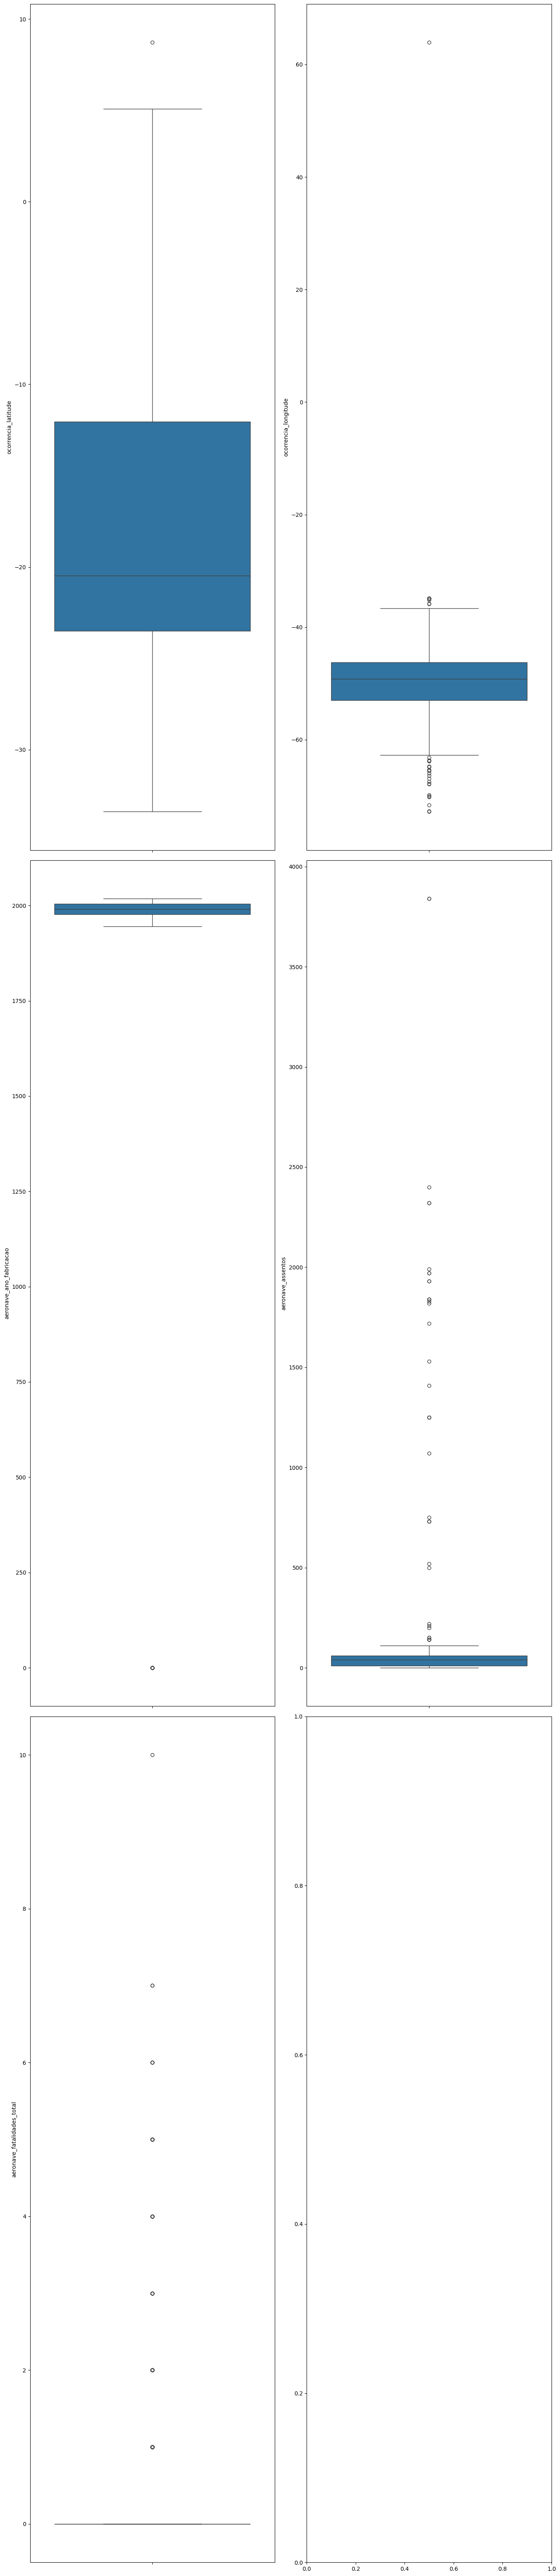

In [728]:
import seaborn as sns

variaveis_numericas = ['ocorrencia_latitude', 'ocorrencia_longitude', 'aeronave_ano_fabricacao', 'aeronave_assentos', 'aeronave_fatalidades_total']

# Configurar o tamanho e layout do gráfico
plt.rcParams["figure.figsize"] = [14.00, 64.00]
plt.rcParams["figure.autolayout"] = True

# Criar um gráfico com 2 linhas e 2 colunas
f, axes = plt.subplots(3, 2)

# Iterar sobre as variáveis numéricas e criar um boxplot para cada uma
linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data=df_modelo, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

# Mostrar o gráfico
plt.show()

# Modelo Preditivo 

In [729]:
df_modelo.shape

(555, 21)

In [730]:
df_modelo.shape
df_modelo.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_saida_pista,ocorrencia_tipo,aeronave_fabricante,aeronave_modelo,aeronave_ano_fabricacao,...,fator_aspecto,ocorrencia_datahora,aeronave_motor_tipo,aeronave_pais_fabricante,aeronave_assentos,aeronave_registro_categoria,aeronave_tipo_operacao,aeronave_fatalidades_total,fator_condicionante,fator_area
0,INCIDENTE GRAVE,-9.868333,-67.898056,AC,SBRB,NÃO,COM PARA-BRISAS / JANELA / PORTA,EMBRAER,EMB-110P1,1980.0,...,DESEMPENHO DO SER HUMANO,2022-04-14 17:45:00,TURBOÉLICE,BRASIL,200.0,AVIÃO,TÁXI AÉREO,0,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,ACIDENTE,-12.204167,-56.237778,MT,Fora de aerodromo,NÃO,OPERAÇÃO A BAIXA ALTITUDE,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,1980.0,...,ASPECTO PSICOLÓGICO,2022-03-24 19:30:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,INDIVIDUAL,FATOR HUMANO
9,ACIDENTE,-19.198333,-45.011667,MG,SNPO,SIM,EXCURSÃO DE PISTA,NEIVA INDUSTRIA AERONAUTICA,EMB-202,2002.0,...,DESEMPENHO DO SER HUMANO,2022-03-13 15:00:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
23,ACIDENTE,-29.055278,-55.716111,RS,Fora de aerodromo,NÃO,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,1993.0,...,ASPECTO PSICOLÓGICO,2022-01-29 09:50:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,INDIVIDUAL,FATOR HUMANO
33,ACIDENTE,-20.356944,-49.526389,SP,Fora de aerodromo,NÃO,OPERAÇÃO A BAIXA ALTITUDE,EMBRAER,EMB-202A,2013.0,...,DESEMPENHO DO SER HUMANO,2022-01-22 21:00:00,PISTÃO,BRASIL,10.0,AVIÃO,AGRÍCOLA,0,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL


Apenas procurando as colunas que possuem valores não-numericos, para poder trata-los

In [731]:

# carregar variaveis categoricas para OneHotEncoding
variaveis_categoricas = []
for i in df_modelo.columns[0:27].tolist():
        if df_modelo.dtypes[i] == 'object' or df_modelo.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)    

In [732]:
variaveis_categoricas


['ocorrencia_classificacao',
 'ocorrencia_uf',
 'ocorrencia_aerodromo',
 'ocorrencia_saida_pista',
 'ocorrencia_tipo',
 'aeronave_fabricante',
 'aeronave_modelo',
 'fator_nome',
 'fator_aspecto',
 'aeronave_motor_tipo',
 'aeronave_pais_fabricante',
 'aeronave_registro_categoria',
 'aeronave_tipo_operacao',
 'fator_condicionante',
 'fator_area']

Aplica valores categoricos para cara uma das colunas não-numericas. Para que o modelo possa analisa-las.

In [733]:
# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_modelo[var] = lb.fit_transform(df_modelo[var])


In [734]:
df_modelo.isnull().sum()

ocorrencia_classificacao       0
ocorrencia_latitude            0
ocorrencia_longitude           0
ocorrencia_uf                  0
ocorrencia_aerodromo           0
ocorrencia_saida_pista         0
ocorrencia_tipo                0
aeronave_fabricante            0
aeronave_modelo                0
aeronave_ano_fabricacao        0
fator_nome                     0
fator_aspecto                  0
ocorrencia_datahora            0
aeronave_motor_tipo            0
aeronave_pais_fabricante       0
aeronave_assentos              0
aeronave_registro_categoria    0
aeronave_tipo_operacao         0
aeronave_fatalidades_total     0
fator_condicionante            0
fator_area                     0
dtype: int64

In [735]:
df_modelo.info()


<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 0 to 6887
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ocorrencia_classificacao     555 non-null    int32         
 1   ocorrencia_latitude          555 non-null    float64       
 2   ocorrencia_longitude         555 non-null    float64       
 3   ocorrencia_uf                555 non-null    int32         
 4   ocorrencia_aerodromo         555 non-null    int32         
 5   ocorrencia_saida_pista       555 non-null    int32         
 6   ocorrencia_tipo              555 non-null    int32         
 7   aeronave_fabricante          555 non-null    int32         
 8   aeronave_modelo              555 non-null    int32         
 9   aeronave_ano_fabricacao      555 non-null    float64       
 10  fator_nome                   555 non-null    int32         
 11  fator_aspecto                555 non-null    int3

In [736]:
del df_modelo['ocorrencia_datahora']

In [737]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = df_modelo.ocorrencia_classificacao.value_counts()
variavel_target


ocorrencia_classificacao
0    442
2    101
1     12
Name: count, dtype: int64

In [738]:
df_modelo.shape

(555, 20)

Aqui estamos dividindo o treinamento, para poder ter uma parte para fazer os testes e medir a acertividade do modelo

In [739]:
# Separate the predictor variables and the target variable
PREDITORES = df_modelo.iloc[:, 0:19]  
TARGET = df_modelo.iloc[:, 19]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(PREDITORES, TARGET, test_size=0.2, random_state=42)

In [740]:
PREDITORES.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_saida_pista,ocorrencia_tipo,aeronave_fabricante,aeronave_modelo,aeronave_ano_fabricacao,fator_nome,fator_aspecto,aeronave_motor_tipo,aeronave_pais_fabricante,aeronave_assentos,aeronave_registro_categoria,aeronave_tipo_operacao,aeronave_fatalidades_total,fator_condicionante
0,2,-9.868333,-67.898056,0,46,0,12,18,104,1980.0,35,5,5,0,200.0,1,9,0,3
1,0,-12.204167,-56.237778,11,4,0,36,36,106,1980.0,2,4,2,0,10.0,1,0,0,0
9,0,-19.198333,-45.011667,9,118,1,21,36,107,2002.0,1,5,2,0,10.0,1,0,0,3
23,0,-29.055278,-55.716111,19,4,0,6,36,107,1993.0,2,4,2,0,10.0,1,0,0,0
33,0,-20.356944,-49.526389,22,4,0,36,18,108,2013.0,1,5,2,0,10.0,1,0,0,3


In [741]:
TARGET.head()

0     2
1     0
9     2
23    0
33    2
Name: fator_area, dtype: int32

In [742]:
PREDITORES.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 0 to 6887
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ocorrencia_classificacao     555 non-null    int32  
 1   ocorrencia_latitude          555 non-null    float64
 2   ocorrencia_longitude         555 non-null    float64
 3   ocorrencia_uf                555 non-null    int32  
 4   ocorrencia_aerodromo         555 non-null    int32  
 5   ocorrencia_saida_pista       555 non-null    int32  
 6   ocorrencia_tipo              555 non-null    int32  
 7   aeronave_fabricante          555 non-null    int32  
 8   aeronave_modelo              555 non-null    int32  
 9   aeronave_ano_fabricacao      555 non-null    float64
 10  fator_nome                   555 non-null    int32  
 11  fator_aspecto                555 non-null    int32  
 12  aeronave_motor_tipo          555 non-null    int32  
 13  aeronave_pais_fabricante

In [743]:
PREDITORES.isnull().sum()


ocorrencia_classificacao       0
ocorrencia_latitude            0
ocorrencia_longitude           0
ocorrencia_uf                  0
ocorrencia_aerodromo           0
ocorrencia_saida_pista         0
ocorrencia_tipo                0
aeronave_fabricante            0
aeronave_modelo                0
aeronave_ano_fabricacao        0
fator_nome                     0
fator_aspecto                  0
aeronave_motor_tipo            0
aeronave_pais_fabricante       0
aeronave_assentos              0
aeronave_registro_categoria    0
aeronave_tipo_operacao         0
aeronave_fatalidades_total     0
fator_condicionante            0
dtype: int64

In [744]:
PREDITORES.dtypes


ocorrencia_classificacao         int32
ocorrencia_latitude            float64
ocorrencia_longitude           float64
ocorrencia_uf                    int32
ocorrencia_aerodromo             int32
ocorrencia_saida_pista           int32
ocorrencia_tipo                  int32
aeronave_fabricante              int32
aeronave_modelo                  int32
aeronave_ano_fabricacao        float64
fator_nome                       int32
fator_aspecto                    int32
aeronave_motor_tipo              int32
aeronave_pais_fabricante         int32
aeronave_assentos              float64
aeronave_registro_categoria      int32
aeronave_tipo_operacao           int32
aeronave_fatalidades_total       int64
fator_condicionante              int32
dtype: object

from imblearn.over_sampling import SMOTE: Esta linha importa a classe SMOTE do módulo imblearn.over_sampling. imblearn é uma biblioteca Python que oferece técnicas de reamostragem para conjuntos de dados desbalanceados.
balanceador = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=100): Aqui, um objeto SMOTE é criado e atribuído à variável balanceador. Os parâmetros passados para SMOTE são:
sampling_strategy='auto': Isso significa que o balanceador irá tentar equilibrar todas as classes para ter o mesmo número de amostras que a classe majoritária.
k_neighbors=2: Isso define o número de vizinhos mais próximos a serem usados para criar amostras sintéticas.
random_state=100: Isso garante que a reamostragem seja reproduzível. Ou seja, se você executar o código novamente, obterá o mesmo resultado.
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORES, TARGET): Esta linha aplica o balanceador aos dados. O método fit_resample faz duas coisas:
Primeiro, ele ajusta o balanceador aos dados (PREDITORES e TARGET). Isso envolve aprender quais são as classes minoritárias que precisam ser reamostradas.
Em seguida, ele cria novas amostras sintéticas e retorna os dados reamostrados. As novas amostras são armazenadas em PREDITORAS_RES e TARGET_RES.


In [745]:
from imblearn.over_sampling import SMOTE

balanceador = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=100)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORES, TARGET)


In [746]:
PREDITORAS_RES.shape


(1524, 19)

In [747]:
TARGET_RES.shape

(1524,)

In [748]:
X_train.shape

(444, 19)

In [749]:
X_train.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_saida_pista,ocorrencia_tipo,aeronave_fabricante,aeronave_modelo,aeronave_ano_fabricacao,fator_nome,fator_aspecto,aeronave_motor_tipo,aeronave_pais_fabricante,aeronave_assentos,aeronave_registro_categoria,aeronave_tipo_operacao,aeronave_fatalidades_total,fator_condicionante
1501,0,-19.908056,-43.985278,9,43,1,21,13,14,1997.0,1,5,2,0,40.0,1,3,0,3
955,0,-10.011389,-67.790000,0,4,0,8,26,69,2009.0,3,4,4,0,60.0,2,6,0,0
3655,0,-20.556667,-46.288611,22,91,0,22,4,73,1994.0,23,5,2,0,10.0,1,0,0,1
6166,0,-26.223056,-48.797500,20,28,0,42,44,173,1995.0,16,5,2,0,20.0,2,3,0,3
1673,2,-21.086389,-44.226389,9,115,1,21,18,110,2009.0,1,5,0,0,60.0,1,7,0,3


Normalizar as variaveis (Normar... tudo normar!!)

In [750]:
# Normalização das Variáveis
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_train)
X_teste_normalizados = Normalizador.transform(X_test)

In [751]:
X_treino_normalizados.shape

(444, 19)

In [752]:
X_treino_normalizados

array([[0.        , 0.32012352, 0.21060729, ..., 0.33333333, 0.        ,
        0.5       ],
       [0.        , 0.55520804, 0.03643348, ..., 0.66666667, 0.        ,
        0.        ],
       [0.        , 0.30471647, 0.19375432, ..., 0.        , 0.        ,
        0.16666667],
       ...,
       [0.        , 0.67702601, 0.05424373, ..., 0.88888889, 0.        ,
        0.        ],
       [0.        , 0.4582723 , 0.14701638, ..., 0.        , 0.14285714,
        0.5       ],
       [0.        , 0.35052842, 0.17616355, ..., 0.        , 0.        ,
        0.5       ]])

Padronizador = StandardScaler(): Aqui, um objeto StandardScaler é criado e atribuído à variável Padronizador. StandardScaler é uma classe da biblioteca sklearn.preprocessing que padroniza recursos removendo a média e escalando para a variância unitária.
X_treino_padronizados = Padronizador.fit_transform(X_train): Esta linha faz duas coisas:
Primeiro, o método fit calcula a média e o desvio padrão dos dados de treinamento (X_train). Isso é necessário para a próxima etapa.
Em seguida, o método transform usa a média e o desvio padrão calculados para padronizar os dados de treinamento. Isso significa que a média dos dados de treinamento padronizados será 0 e o desvio padrão será 1. Os dados de treinamento padronizados são armazenados em X_treino_padronizados.
X_teste_padronizados = Padronizador.transform(X_test): Esta linha usa a média e o desvio padrão dos dados de treinamento (calculados anteriormente) para padronizar os dados de teste (X_test). É importante usar a mesma média e desvio padrão para garantir que os dados de treinamento e teste estejam na mesma escala. Os dados de teste padronizados são armazenados em X_teste_padronizados.

In [753]:
# Padronizacao das Variáveis
Padronizador = StandardScaler()
X_treino_padronizados = Padronizador.fit_transform(X_train)
X_teste_padronizados = Padronizador.transform(X_test)

In [754]:
X_treino_padronizados

array([[-0.49029836, -0.24436552,  0.66490652, ..., -0.46758166,
        -0.38651377,  0.62327447],
       [-0.49029836,  0.87597389, -2.14052348, ...,  0.43899589,
        -0.38651377, -1.59651589],
       [-0.49029836, -0.3177907 ,  0.39345447, ..., -1.37415922,
        -0.38651377, -0.85658577],
       ...,
       [-0.49029836,  1.45652028, -1.8536525 , ...,  1.04338092,
        -0.38651377, -1.59651589],
       [-0.49029836,  0.41400841, -0.35935681, ..., -1.37415922,
         0.41168211,  0.62327447],
       [-0.49029836, -0.09946527,  0.11011878, ..., -1.37415922,
        -0.38651377,  0.62327447]])

# Criando, Treinando e Avaliando os Modelos de Machine Learning

In [755]:
randomForest = RandomForestClassifier()

Primeiro, ele define os valores possíveis para cada hiperparâmetro que você deseja otimizar. Isso inclui o número de estimadores (n_estimators), a profundidade máxima das árvores (max_depth), o critério de qualidade da divisão (criterion), o número de recursos a considerar ao procurar a melhor divisão (max_features), o número mínimo de amostras necessárias para dividir um nó interno (min_samples_split) e o número mínimo de amostras necessárias para estar em um nó folha (min_samples_leaf).
Em seguida, ele cria um dicionário (grid_parametros) com todos os valores dos hiperparâmetros.
Ele cria um objeto GridSearchCV com o modelo de Floresta Aleatória (randomForest), o dicionário de hiperparâmetros e outros parâmetros como o número de dobras para a validação cruzada (cv) e o número de trabalhos para executar em paralelo (n_jobs).
Ele treina o modelo usando o método fit no conjunto de treinamento padronizado (X_treino_normalizados e y_train). Ele também registra o tempo de início e fim para calcular o tempo total de treinamento.
Ele obtém os resultados do treinamento e os armazena em um DataFrame do pandas (treinos_rf).
Finalmente, ele imprime a melhor pontuação obtida durante o treinamento (acurácia), os melhores hiperparâmetros encontrados, o tempo total de treinamento e o número total de treinamentos realizados.

In [756]:
import time 

# Valores para o grid de hiperparametros
n_estimators = np.array([100,200,300])
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2", None])
min_samples_split = np.array([1,2,5])
min_samples_leaf = np.array([1,2,3])


# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)

# Criando o modelo com o Grid de Hiperparametros
randomForest = GridSearchCV(randomForest, grid_parametros, cv = 3, n_jobs = 8)

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_treino_normalizados, y_train)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])



Acurácia em Treinamento: 100.00%

Hiperparâmetros Ideais: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Tempo de Treinamento do Modelo:  277.73

Numero de treinamentos realizados:  324


In [757]:
treinos_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_fit_time            324 non-null    float64
 1   std_fit_time             324 non-null    float64
 2   mean_score_time          324 non-null    float64
 3   std_score_time           324 non-null    float64
 4   param_criterion          324 non-null    object 
 5   param_max_depth          324 non-null    object 
 6   param_max_features       216 non-null    object 
 7   param_min_samples_leaf   324 non-null    object 
 8   param_min_samples_split  324 non-null    object 
 9   param_n_estimators       324 non-null    object 
 10  params                   324 non-null    object 
 11  split0_test_score        216 non-null    float64
 12  split1_test_score        216 non-null    float64
 13  split2_test_score        216 non-null    float64
 14  mean_test_score          2

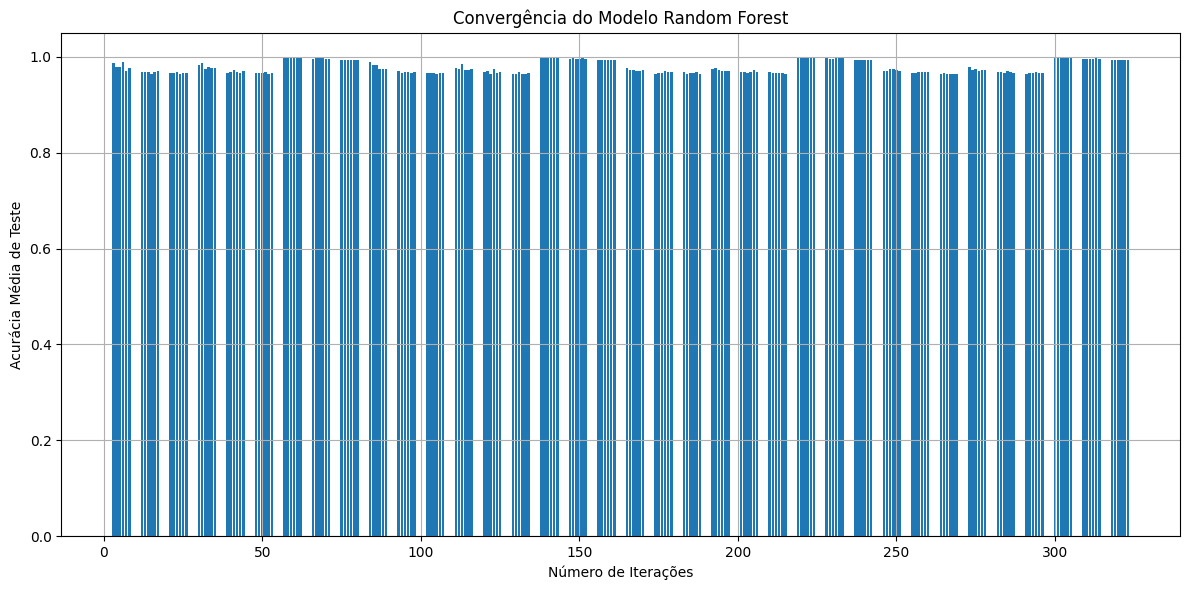

In [758]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(treinos_rf['mean_test_score'])), treinos_rf['mean_test_score'])
plt.title('Convergência do Modelo Random Forest')
plt.xlabel('Número de Iterações')
plt.ylabel('Acurácia Média de Teste')
plt.grid(True)
plt.show()

In [759]:
from sklearn.ensemble import RandomForestClassifier

# Crie um classificador Random Forest
clf = RandomForestClassifier(n_estimators=100, criterion='entropy',
                            max_features='log2', min_samples_leaf=1, min_samples_split=2, n_jobs=8)

# Ajuste o classificador aos dados de treinamento
clf.fit(X_treino_normalizados, y_train)


RandomForestClassifier(criterion='entropy', max_features='log2', n_jobs=8)

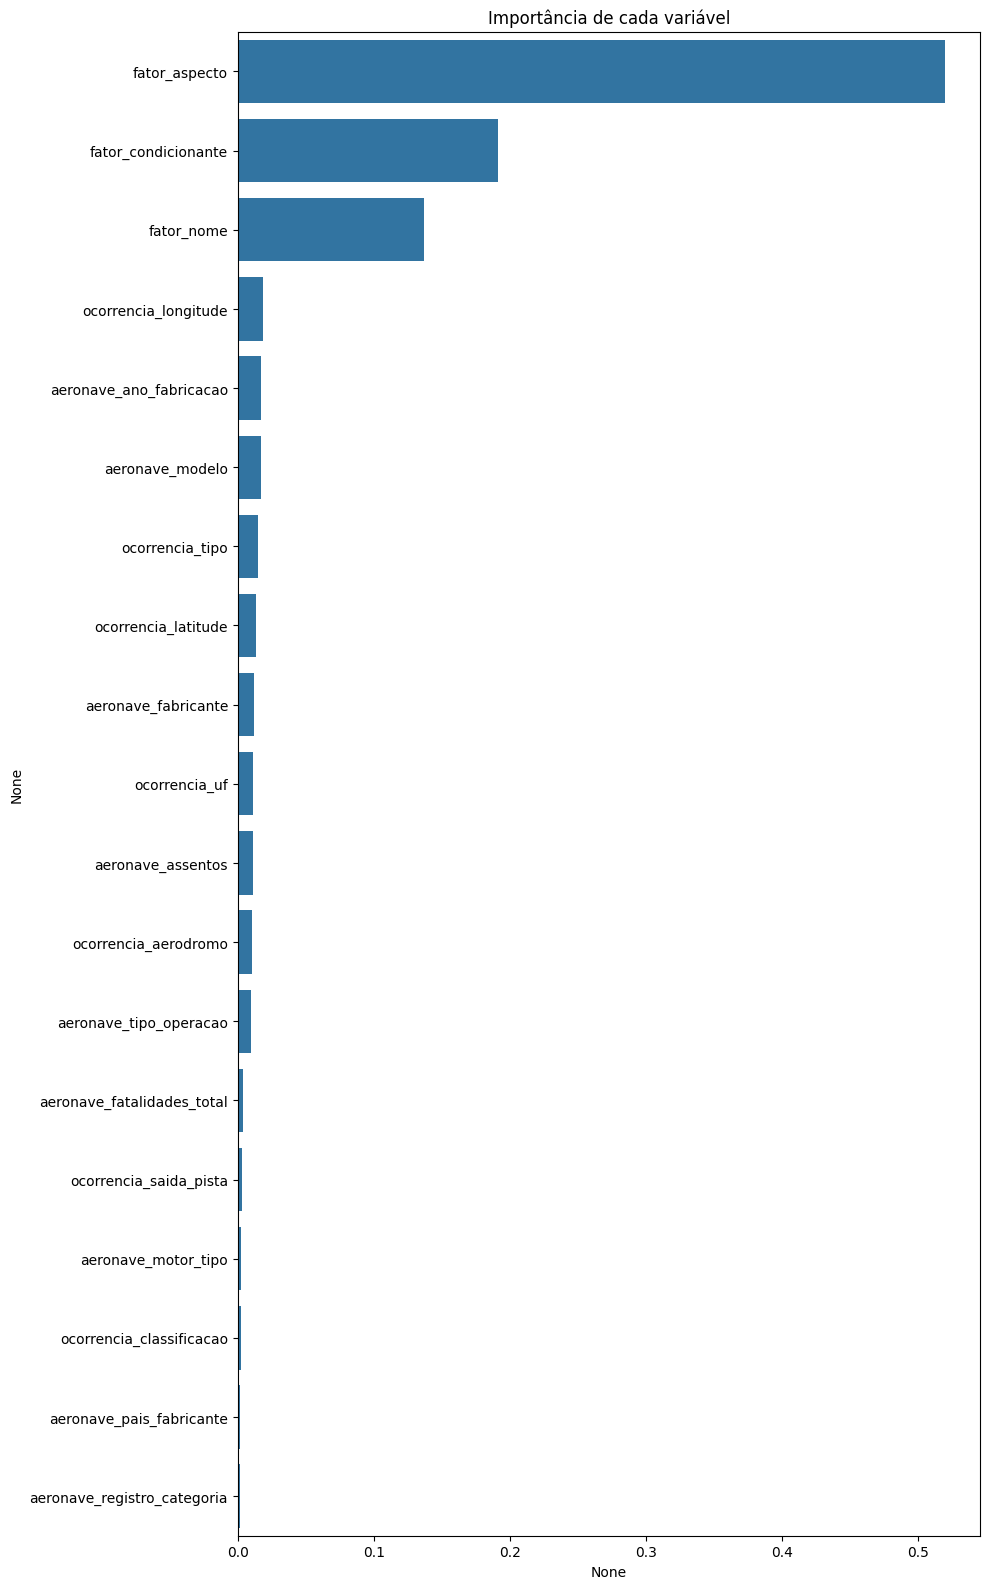

In [760]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 16.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORES.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [761]:
print(treinos_rf.columns)


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_max_features',
       'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


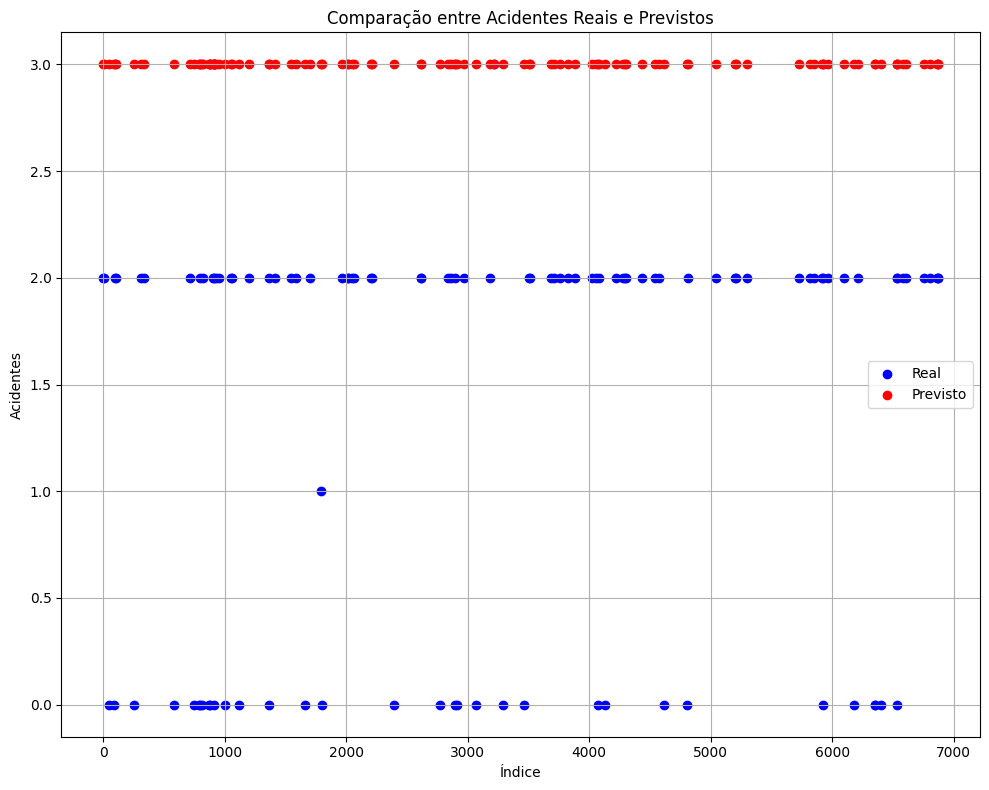

In [762]:

y_pred = randomForest.predict(X_test)

df = pd.DataFrame({'Real': y_test, 'Previsto': y_pred})

# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 8))
plt.scatter(df.index, df['Real'], color='blue', label='Real')
plt.scatter(df.index, df['Previsto'], color='red', label='Previsto')

plt.grid(True)

plt.title('Comparação entre Acidentes Reais e Previstos')
plt.xlabel('Índice')
plt.ylabel('Acidentes')
plt.legend()

# Mostrando o gráfico
plt.show()


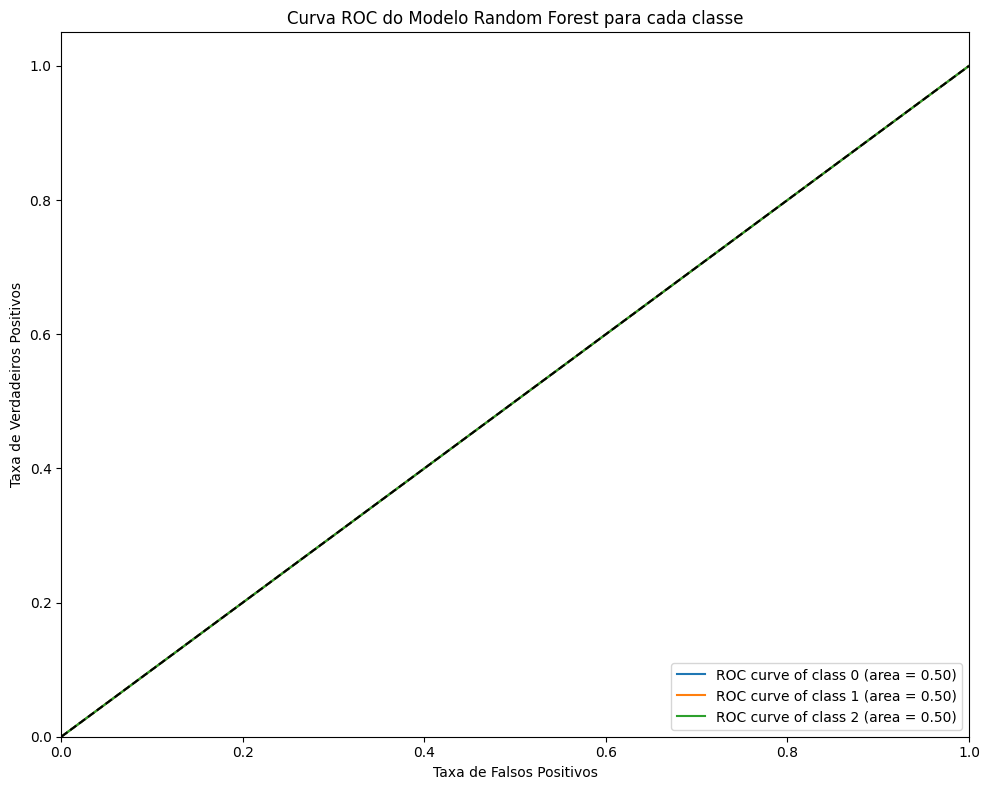

In [768]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y.shape[1]

# Fazendo previsões com o modelo
y_score = randomForest.predict_proba(X_test)

# Calculando a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotando a curva ROC para cada classe
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC do Modelo Random Forest para cada classe')
plt.legend(loc="lower right")
plt.show()


In [763]:
scores = clf.score(X_treino_normalizados,y_train)
scores

1.0

In [764]:
scores = clf.score(X_teste_normalizados,y_test)
scores

0.972972972972973